## MNIST Image Classification with an MLP Model

### Build the dataset and dataloader

In [41]:
import torch
import torchvision
from torchvision import transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Visualize samples from the dataset

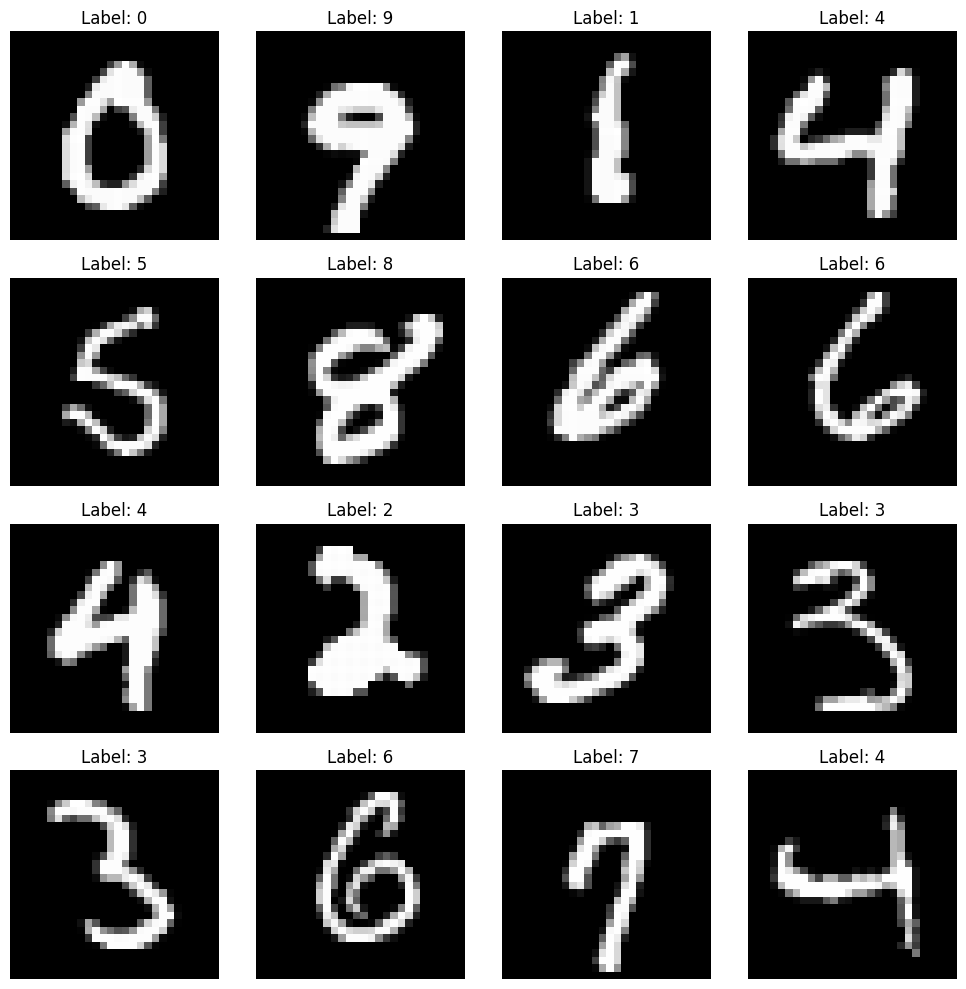

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Get 16 random indices
indices = np.random.choice(len(train_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


### Build an MLP Model

In [43]:
import torch
import torch.nn as nn
from einops import rearrange
from einops.layers.torch import Rearrange
import math

class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        
        self.flatten = Rearrange('b ... -> b (...)')
        
        # First layer (fc1)
        self.weights1 = nn.Parameter(
            torch.randn(input_size, hidden_size)
        )
        self.weights1 = nn.init.xavier_normal_(self.weights1)
        self.bias1 = nn.Parameter(torch.zeros(hidden_size))
        
        # Second layer (fc2)
        self.weights2 = nn.Parameter(
            torch.randn(hidden_size, num_classes)
        )
        self.weights2 = nn.init.xavier_normal_(self.weights2)
        self.bias2 = nn.Parameter(torch.zeros(num_classes))
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Flatten the input tensor
        x = self.flatten(x)
        
        # First layer
        y = torch.einsum('bi,ij->bj', x, self.weights1) + self.bias1
        y = self.relu(y)
        
        # Second layer
        y = torch.einsum('bi,ij->bj', y, self.weights2) + self.bias2
        
        return y

# Create an instance of the MLP model
model = MLP()
x = torch.randn(64, 1, 28, 28)
print(model)
print(model(x).shape)

# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params:,}")

MLP(
  (flatten): Rearrange('b ... -> b (...)')
  (relu): ReLU()
)
torch.Size([64, 10])
Number of parameters: 101,770


### Define the loss function and optimizer

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [45]:
from tqdm import tqdm

num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


 10%|█         | 1/10 [00:02<00:26,  2.92s/it]

Epoch: 1, Loss: 0.3504


 20%|██        | 2/10 [00:05<00:21,  2.73s/it]

Epoch: 2, Loss: 0.1830


 30%|███       | 3/10 [00:08<00:18,  2.69s/it]

Epoch: 3, Loss: 0.1347


 40%|████      | 4/10 [00:10<00:16,  2.67s/it]

Epoch: 4, Loss: 0.1133


 50%|█████     | 5/10 [00:13<00:13,  2.71s/it]

Epoch: 5, Loss: 0.0963


 60%|██████    | 6/10 [00:16<00:10,  2.71s/it]

Epoch: 6, Loss: 0.0855


 70%|███████   | 7/10 [00:19<00:08,  2.72s/it]

Epoch: 7, Loss: 0.0752


 80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

Epoch: 8, Loss: 0.0693


 90%|█████████ | 9/10 [00:24<00:02,  2.77s/it]

Epoch: 9, Loss: 0.0628


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]

Epoch: 10, Loss: 0.0579


### Evaluate the model

In [46]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9689


### Predict on sample images

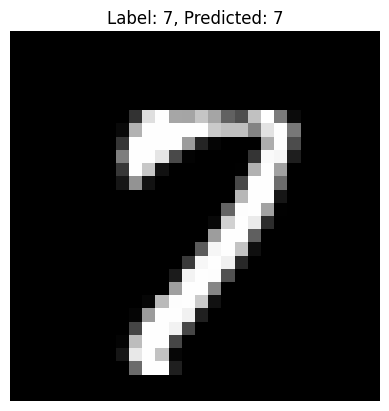

In [47]:
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Move the image to the device
image = image.to(device)

# Forward pass to get the predicted label
output = model(image.unsqueeze(0))
_, predicted_label = torch.max(output, 1)

# Convert the image tensor to a numpy array
image_np = image.cpu().numpy()

# Display the image, its label, and the predicted label
plt.imshow(image_np.squeeze(), cmap='gray')
plt.title(f"Label: {label}, Predicted: {predicted_label.item()}")
plt.axis('off')
plt.show()
